100%|██████████| 1000/1000 [22:13<00:00,  1.33s/it, Loss=0.0018420698]


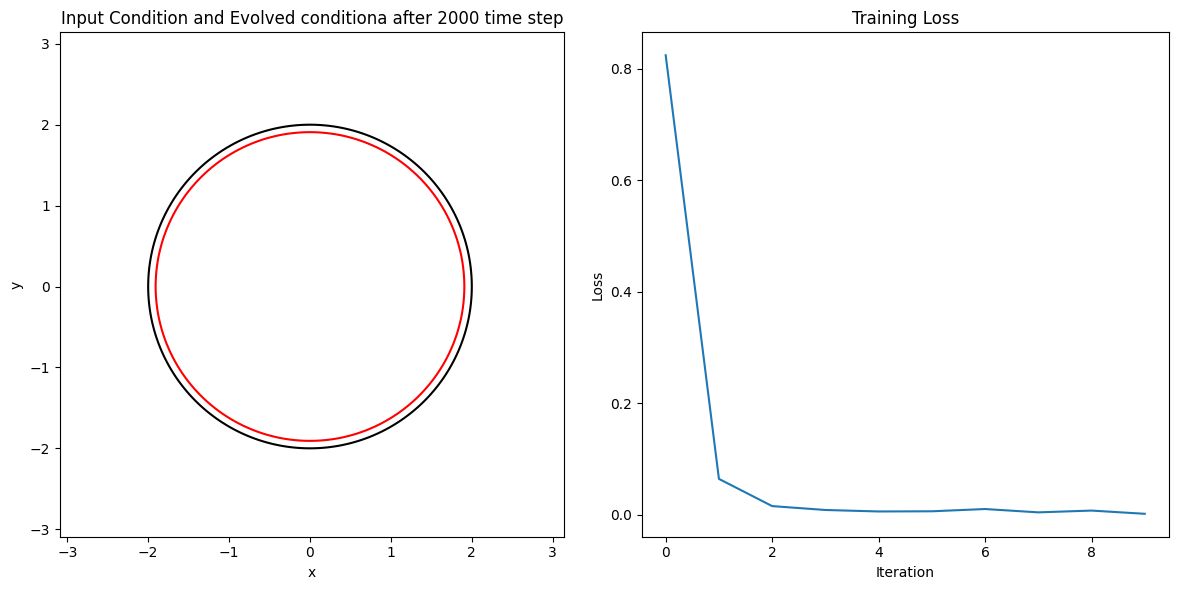

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP




def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))




# Define normalization and denormalization functions
def normalize(data):
   mean = jnp.mean(data)
   std = jnp.std(data)
   return (data - mean) / std, mean, std


def denormalize(data, mean, std):
   return data * std + mean



class SPiFOL:
   def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
       self.arch = arch
       self.N = N
       self.lr = lr
       # self.norm_par = norm_par
       self.eps = eps
       self.pp2 = pp2
       self.qq2 = qq2
       self.dt = dt
       self.L = L
       self.h = h
       self.x = x
       self.y = y
       # Initialize the network based on architecture type
       if arch == 'FNO':
           self.N_init, self.N_apply = serial(*fno_layers)
           _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
          
       elif arch == 'MLP':
           self.N_init, self.N_apply = MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
          
       elif arch == 'modified_MLP':
           self.N_init, self.N_apply = modified_MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
       else:
           raise ValueError("Unsupported architecture!")


       self.params = params


    
       # Optimizer setup
       self.opt_init, self.opt_update, self.get_params = complex_adam(
           jax.example_libraries.optimizers.exponential_decay(
               lr, decay_steps=2000, decay_rate=0.9)
           )
      
       self.opt_state = self.opt_init(self.params)


       # Logging losses
       self.total_loss_log = []
       self.total_energy_loss_log = []


       # Initialize optimizer state
       self.opt_state = self.opt_init(self.params)
       self.itercount = iter(range(50000))


   @partial(jit, static_argnums=(0,))
   def operator_net(self, params, uk):
       if self.arch == 'FNO':
           uk = uk.reshape(-1, self.N, self.N, 1)  # Reshape input 
           O = self.N_apply(params, uk)  # Apply the FNO network
           O = jnp.real(O)  # Take the real part of the output
           O = O.reshape(self.N, self.N)  # Reshape output
           return O
       elif self.arch == 'MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)  # Directly apply the network
           O = O.reshape(self.N, self.N)  # Reshape output to match strain components
           # O = O / self.norm_par  # Normalize the output
           return O
       elif self.arch == 'modified_MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)
           O = O.reshape(self.N, self.N)
           return O
       else:
           raise ValueError("Unsupported architecture type!")
      

   def allen_cahn_equation(self, uk, total_steps=2000):
        for _ in range(total_steps):
            cahn = eps**2
            uk = jnp.real(uk)
            # Allen-Cahn equation in Fourier space
            s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))
            v_hat = s_hat / (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2)))
            uk = jfft.ifft2(v_hat)  # Update uk to the next state
        # uk = np.load('final_output.npy_20000.npy')
            # print(f'shree is my heart')

        return jnp.real(uk)  # Return only the final state
   

   @partial(jit, static_argnums=(0,))
   def loss_single(self, params, uk):
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N)
        u_ac = self.allen_cahn_equation(uk)
        
        # Allen-Cahn equation loss
    #    energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
    #    total_loss = distance_loss + energy_loss
        return datadriven_loss
   

   @partial(jit, static_argnums=(0,))
   def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk)
        return self.opt_update(i, grads, opt_state)


   def train(self, uk, nIter=1000):
        pbar = trange(nIter)
        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk)
    #    self.itercount = iter(range(nIter))  # Create an iterator
            



            # Logger (log the loss every 100 iterations)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk)
                self.total_loss_log.append(loss)
                # self.total_energy_loss_log.append(energy_loss)
                pbar.set_postfix({'Loss': loss})


# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)

 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)


# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
#    Permute("ijkl->iljk"),
#    FNOBlock2D(32),
   Gelu,  # activation can be changed here
#    FNOBlock2D(32),
#    Gelu,
#    FNOBlock2D(32),
#    Permute("ijkl->iklj"),
   Dense(32),
   Gelu,
   Dense(1),
]



cahn = eps**2
for arch in arch_list:
   # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
    # final_state = model.allen_cahn_equation(input_condition)
    model.train(input_condition, nIter=1000)


params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, input_condition).reshape(N, N)



# Plot the initial and final states
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Input condition plot
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="black")
axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="red")

axs[0].set_title('Input Condition and Evolved conditiona after 2000 time step')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


# #    # Plot loss
axs[1].plot(model.total_loss_log)
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')






plt.tight_layout()
plt.show()

            

## Data generation 

## Data save (train_data and test data)


Generated 1 samples with shape: (1, 128, 128, 1)
Generated 1 samples with shape: (1, 128, 128, 1)
Training data shape (u_train): (1, 128, 128, 1)
Testing data shape (u_test): (1, 128, 128, 1)
Saving training data...
Saving testing data...
Data saving completed!


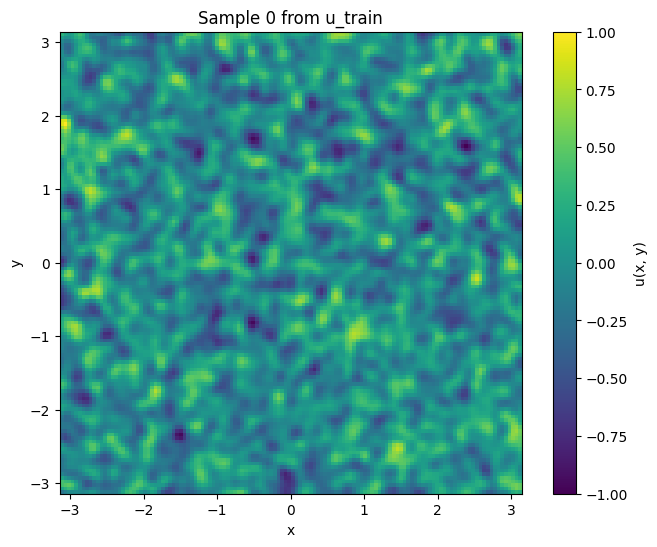

In [6]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2))
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for _ in range(n_samples):
        # print(f'for sample {i+1}')
        # Select random length scale
        length_scale = random.choice(key, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale)
        jitter = 1e-5
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        # eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)

    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, train_num, test_num):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.train_num = train_num
        self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.u_train = self.u_data(self.train_num)
        _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        # Normalize and reshape the samples
        us = normalize(us)
        us = us.reshape(-1, self.n_grid, self.n_grid, 1)

        print(f"Generated {n_samples} samples with shape: {us.shape}")

        return X, us


# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 128  # Number of grid points per dimension
    length_scale_list = [0.1, 0.5, 1.0, 2.0]  # Kernel length scales # its indicate the smoothness of the data 
    train_samples = 1 # Number of training samples
    test_samples = 1  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, train_samples, test_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))

    print("Saving testing data to u_test.npy...")
    np.save(os.path.join(save_dir, "u_test_dg.npy"), np.array(data.u_test))

    print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points




    # # Specify the directory where you want to save the data
    # save_dir = './data_generation/'

    # # Ensure the directory exists, create it if not
    # os.makedirs(save_dir, exist_ok=True)

    # # Save the data with the full path to the specific folder
    # np.save(os.path.join(save_dir, "u_train_dg.npy"), np.array(data.u_train))
    # np.save(os.path.join(save_dir, "u_test_dg.npy"), np.array(data.u_test))



# # Save the training and testing data
# np.save("u_train_dg.npy", np.array(data.u_train))
# np.save("u_test_dg.npy", np.array(data.u_test))

# # # Save the grid points (optional, if you want to reconstruct spatial locations)
# np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.u_train[sample_index, :, :, 0]  # Extract the 2D array for the sample
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from u_train")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## This is for single sample

Sample min: -1.0
Sample max: 1.0
Sample mean: -0.023240553215146065
Number of NaN values: 0


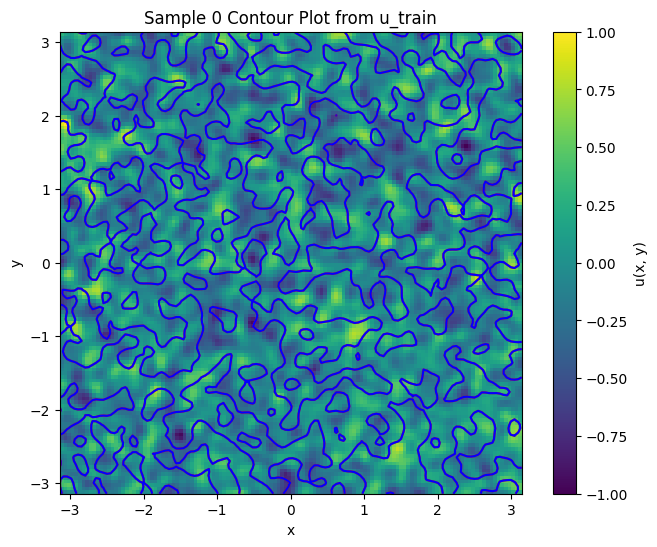

In [16]:
print(f"Sample min: {np.min(sample)}")
print(f"Sample max: {np.max(sample)}")
print(f"Sample mean: {np.mean(sample)}")

print(f"Number of NaN values: {np.sum(np.isnan(sample))}")


# for i in range(5):
#     sample = data.u_train[i, :, :, 0]  # Check first 5 samples
#     plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
#     plt.title(f"Sample {i}")
#     plt.colorbar(label="u(x, y)")
#     plt.show()






# # Plot the sample using contour plot
# plt.figure(figsize=(8, 6))
# # Contour plot
# plt.contourf(sample, levels=50, cmap='viridis', extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi])
# plt.colorbar(label="u(x, y)")
# plt.title(f"Sample {sample_index} from u_train")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

# Ensure sample_index is within bounds
sample_index = 0  # Choose the sample index (e.g., the first one)
if sample_index >= data.u_train.shape[0]:
    raise IndexError(f"sample_index {sample_index} is out of bounds for u_train with shape {data.u_train.shape}")

# Extract the sample (2D array)
sample = data.u_train[sample_index, :, :, 0]  # This extracts the 2D array of shape (128, 128)
sample_1 = data.u_train[sample_index, :, :, 1]  # This extracts the 2D array of shape (128, 128)

# Create the grid points (xx, yy)
x1, x2, y1, y2 = data.x  # domain limits
xx, yy = jnp.meshgrid(
    jnp.linspace(x1, x2, data.n_grid), jnp.linspace(y1, y2, data.n_grid)
)

# Plot using contour
plt.figure(figsize=(8, 6))
contour = plt.contour(xx, yy, jnp.real(sample.T), [0], colors='red')  # Contour at level 0 (can change levels)
contour = plt.contour(xx, yy, jnp.real(sample_1.T), [0], colors='blue')  # Contour at level 0 (can change levels)

plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')

plt.colorbar(label="u(x, y)")  # Add color bar for better understanding
plt.title(f"Sample {sample_index} Contour Plot from u_train")
plt.title(f"Sample {sample_index} Contour Plot from u_train")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



## Given sample_1 input on Allen cahn and check its work or not

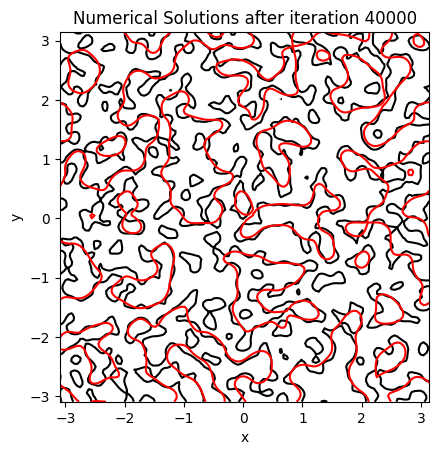

In [26]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter






# difinning the no of grid points in x, y and z
Nx = 128 # number of grid points in x be positive even integer number
Ny = 128 # number of grid points in y be positive even integer number
Nz = 128 # number of grid points in z be positive even integer number



# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# defining parameters for the Allen-Cahn equation
#It determines the scale of the transition region (interface width) between phases. its the width of the interface, smaller epsillon refer to the sharp transition

epsillon = 0.05 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
# uk =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# theta = jnp.arctan(y/x)
# u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))
uk = sample_1

# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
#print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # plotting the initial condition of the Allen-Cahn equation


#this figure code is pervious code 
figure1 = plt.figure()
plt.contour(x, y, jnp.real(uk.T), [0], colors = 'black')
plt.gca().set_aspect('equal', adjustable='box') 
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('y')
# plt.show()


# # providing the range of iteration

for iter in range(1, Nt):
    u = jnp.real(uk)
    # print(f'real space u ko size ={u.shape}')
    # Transforming the solution to the discrete Fourier space
    s_hat = jfft.fft2(cahn * u - dt * (u**3 - 3 * u)) # us is the real space
    # print(f's_hat ko size = {s_hat.shape}')
    v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))  # Allen-Cahn equation
    uk = jfft.ifft2(v_hat)  # u_k+1 result
    # print(f'inverse u ko size = {u.shape}')



    if iter == 100:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')
        
    # if iter == 4000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='green')
    #     plt.gca().set_aspect('equal', adjustable='box')
    
    # if iter == 10000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='blue')
    #     plt.gca().set_aspect('equal', adjustable='box')

    # if iter == 20000:
    #     plt.contour(x, y, jnp.real(uk.T), [0], colors='pink')
    #     plt.gca().set_aspect('equal', adjustable='box')


plt.title('Numerical Solutions after iteration ' + str(Nt))
plt.show()

